In [104]:
from netCDF4 import Dataset,num2date 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import time
import xarray as xr
import utm
import openpyxl
import pandas as pd
import json
import re
import math

In [55]:
def dms2dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction == 'S' or direction == 'W':
        dd *= -1
    return dd;

def dd2dms(deg):
    d = int(deg)
    md = abs(deg - d) * 60
    m = int(md)
    sd = (md - m) * 60
    return [d, m, sd]

def parse_dms(dms):
    parts = re.split('[^\d\w]+', dms)
    lat = dms2dd(parts[0], parts[1], parts[2], parts[3])
    lng = dms2dd(parts[4], parts[5], parts[6], parts[7])

    return (lat, lng)

## Wells from NPD

In [59]:
wb = openpyxl.load_workbook(filename = '/Users/guttorm/Dropbox/Projects/ACTOM/Coding/Data/Norwegian site/Export.xlsx')
ws = wb['Wellbores, all']

from itertools import islice
data = ws.values
cols = next(data)[1:]
data = list(data)
idx = [r[0] for r in data]
data = (islice(r, 1, None) for r in data)
df = pd.DataFrame(data, index=idx, columns=cols)

#%%
df.set_index(df['OBJECTID'],inplace=True)
cols=['NS UTM [m]','EW UTM [m]','NS degrees','NS minutes','NS seconds','EW degrees','EW minutes','EW seconds','NS decimal degrees','EW decimal degrees','UTM zone','EW code','NS code','Water depth [m]','Well name']
wells=df[cols].to_xarray()
well_utm=df[['NS UTM [m]','EW UTM [m]']].to_xarray()

In [90]:
Earr=[]
Narr=[]
for ii in wells.OBJECTID.values:
    tmp=wells.sel(OBJECTID=ii)
    tmpN=dms2dd(tmp['NS degrees'], tmp['NS minutes'], tmp['NS seconds'], tmp['NS code'])
    tmpE=dms2dd(tmp['EW degrees'], tmp['EW minutes'], tmp['EW seconds'], 'E')
    print('ii',ii,'tmpN',tmpN,'tmpE', tmpE, 'utm',utm.from_latlon(tmpN,tmpE))
   
    E,N,_,_=utm.from_latlon(tmpN,tmpE)
    Earr.append(E)
    Narr.append(N)



ii 33 tmpN 62.184444444444445 tmpE 5.448888888888889 utm (315194.669670284, 6899795.3094265945, 32, 'V')
ii 34 tmpN 60.6325 tmpE 5.471388888888889 utm (307014.5914824476, 6727036.007971283, 32, 'V')
ii 104 tmpN 60.635555555555555 tmpE 4.382777777777777 utm (247559.73538309472, 6731066.788999934, 32, 'V')
ii 126 tmpN 62.26888888888889 tmpE 4.061388888888889 utm (243791.69631673663, 6913917.592322665, 32, 'V')
ii 403 tmpN 60.78472222222222 tmpE 4.365555555555556 utm (247791.81208512755, 6747718.866565937, 32, 'V')
ii 497 tmpN 62.184444444444445 tmpE 5.448888888888889 utm (315194.669670284, 6899795.3094265945, 32, 'V')
ii 2627 tmpN 60.77194444444444 tmpE 4.168611111111111 utm (236982.2992448263, 6747071.860851002, 32, 'V')
ii 5036 tmpN 61.581944444444446 tmpE 4.343333333333333 utm (252910.03304652355, 6836447.908906315, 32, 'V')
ii 8064 tmpN 61.53777777777778 tmpE 4.650833333333334 utm (268880.16638313467, 6830406.874177624, 32, 'V')
ii 8090 tmpN 61.54416666666667 tmpE 4.375277777777778 u

In [113]:
 lat=[]
 lng=[]
 for ii in wells.OBJECTID.values:
   tmp=wells.sel(OBJECTID=ii)
   EW=tmp["EW UTM [m]"]
   if int(math.log10(EW))+1 == 8:
      EW=EW/100
   else:
      EW=EW/10
   
   NS=tmp["NS UTM [m]"]
   if int(math.log10(NS))+1 == 9:
      NS=NS/100
   else:
      NS=NS/10

   x,y=utm.to_latlon(EW,NS,31,northern=True)

   lat.append(x)
   lng.append(y)

lng

[<xarray.DataArray ()>
 array(3.91557506)
 Coordinates:
     OBJECTID  int64 33,
 <xarray.DataArray ()>
 array(3.99830745)
 Coordinates:
     OBJECTID  int64 34,
 <xarray.DataArray ()>
 array(3.80590359)
 Coordinates:
     OBJECTID  int64 104,
 <xarray.DataArray ()>
 array(3.93470221)
 Coordinates:
     OBJECTID  int64 126,
 <xarray.DataArray ()>
 array(3.80573139)
 Coordinates:
     OBJECTID  int64 403,
 <xarray.DataArray ()>
 array(3.91557506)
 Coordinates:
     OBJECTID  int64 497,
 <xarray.DataArray ()>
 array(4.07696283)
 Coordinates:
     OBJECTID  int64 2627,
 <xarray.DataArray ()>
 array(4.33355964)
 Coordinates:
     OBJECTID  int64 5036,
 <xarray.DataArray ()>
 array(4.15511663)
 Coordinates:
     OBJECTID  int64 8064,
 <xarray.DataArray ()>
 array(4.15236084)
 Coordinates:
     OBJECTID  int64 8090]

In [114]:

xarr=xr.Dataset(
    data_vars=dict(
    x=(["num"], lat),
    y=(["num"], lng))
    )

xarr

<xarray.Dataset>
Dimensions:  (num: 10)
Dimensions without coordinates: num
Data variables:
    x        (num) float64 60.58 60.5 60.62 60.7 ... 60.72 60.78 60.51 60.51
    y        (num) float64 3.916 3.998 3.806 3.935 ... 4.077 4.334 4.155 4.152

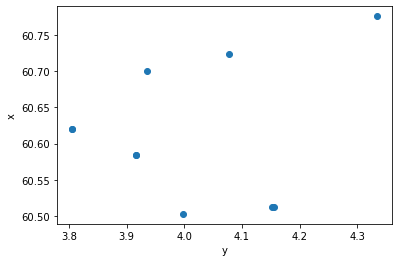

In [116]:
xarr.plot.scatter(x='y',y='x')

In [46]:
with open('leak_coordinates.txt') as f:
#    w, h = [float(x) for x in next(f).split()] # read first line
    E = []
    N=[]
    for line in f: # read rest of lines
       e,w=  [float(x) for x in line.split()]
       E.append(e)
       N.append(w)




In [60]:
well_utm

<xarray.Dataset>
Dimensions:     (OBJECTID: 10)
Coordinates:
  * OBJECTID    (OBJECTID) int64 33 34 104 126 403 497 2627 5036 8064 8090
Data variables:
    NS UTM [m]  (OBJECTID) int64 671683154 670781842 ... 67089675 670897196
    EW UTM [m]  (OBJECTID) int64 5501644 55483484 54410697 ... 56342977 56327833

In [52]:
coord=xr.Dataset(
     data_vars=dict(
         x=(["num"], E),
        y=(["num"], N))
    )
coord

<xarray.Dataset>
Dimensions:  (num: 60)
Dimensions without coordinates: num
Data variables:
    x        (num) float64 5.566e+05 5.568e+05 5.571e+05 ... 5.585e+05 5.585e+05
    y        (num) float64 6.74e+06 6.74e+06 6.739e+06 ... 6.725e+06 6.724e+06

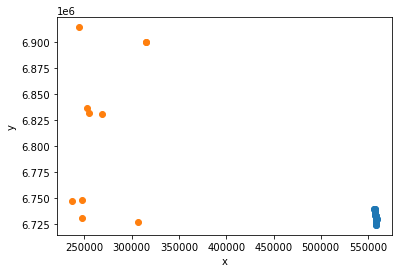

In [82]:

coord.plot.scatter(x='x',y='y')
xarr.plot.scatter(x='x',y='y')

## Velocities from NorKyst

In [8]:
xd= xr.open_dataset('https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2018120500.nc')
# %%
xd

<xarray.Dataset>
Dimensions:                  (X: 2602, Y: 902, depth: 16, s_rho: 35, time: 24)
Coordinates:
  * time                     (time) datetime64[ns] 2018-12-05 ... 2018-12-05T...
  * X                        (X) float64 0.0 800.0 ... 2.08e+06 2.081e+06
  * Y                        (Y) float64 0.0 800.0 1.6e+03 ... 7.2e+05 7.208e+05
  * depth                    (depth) float64 0.0 3.0 10.0 ... 1e+03 2e+03 3e+03
    lon                      (Y, X) float64 ...
    lat                      (Y, X) float64 ...
Dimensions without coordinates: s_rho
Data variables: (12/20)
    Cs_r                     (s_rho) float64 ...
    hc                       float64 ...
    projection_stere         int32 ...
    forecast_reference_time  datetime64[ns] ...
    angle                    (Y, X) float64 ...
    h                        (Y, X) float64 ...
    ...                       ...
    Uwind                    (time, Y, X) float32 ...
    Vwind                    (time, Y, X) float32 ...
    tke                      (time, depth, Y, X) float32 ...
    vbar                     (time, Y, X) float32 ...
    w                        (time, depth, Y, X) float32 ...
    AKs                      (time, depth, Y, X) float32 ...
Attributes: (12/34)
    file:                            /home/metno_op/run/norkyst-800m_2017/oce...
    type:                            ROMS/TOMS history file
    title:                           NorKyst-800m - ROMS
    var_info:                        /home/metno_op/sea/ROMS/metroms/apps/com...
    rst_file:                        /home/metno_op/run/norkyst-800m_2017/oce...
    his_file:                        /home/metno_op/run/norkyst-800m_2017/oce...
    ...                              ...
    CPP_options:                     NORKYST800M, ADD_FSOBC, ADD_M2OBC, ALBED...
    Conventions:                     CF-1.4, SGRID-0.3
    NCO:                             "4.5.4"
    history:                         Thu Jun 13 13:45:28 2019: ncks -A -v for...
    history_of_appended_files:       Thu Jun 13 13:45:28 2019: Appended file ...
    DODS_EXTRA.Unlimited_Dimension:  time

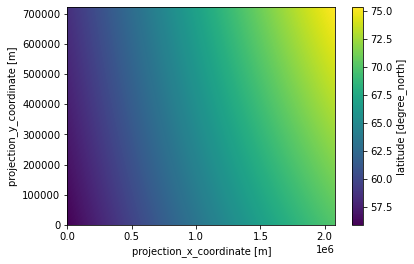

In [9]:
xd.lat.plot()